In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-misc-52ch-125hz/y_test.csv
/kaggle/input/eeg-misc-52ch-125hz/y_train.csv
/kaggle/input/eeg-misc-52ch-125hz/access.ipynb
/kaggle/input/eeg-misc-52ch-125hz/data.h5


In [2]:
from pathlib import Path

# The dataset path
PATH = Path('/kaggle/input/eeg-misc-52ch-125hz')

In [3]:
def epoching(input_signal, label):
    segment_length =  2 * 125 
    num_segments = input_signal.shape[1] // segment_length
    input_signal = input_signal[:, :num_segments * segment_length]
    splitted_signal = input_signal.reshape(-1, input_signal.shape[0], segment_length)
    splitted_label = np.full(num_segments, label)
    return splitted_signal, splitted_label

In [4]:
import h5py
import wandb
from tqdm.notebook import tqdm

wandb.login(key='4a14ae04a51206a6d72f68f667cdf5a33d65d259')
y_train = pd.read_csv(PATH / 'y_train.csv')
y_test = pd.read_csv(PATH / 'y_test.csv')

train_data = []
test_data = []
train_label = []
test_label = []

with h5py.File(PATH / 'data.h5', 'r') as f:
    min_len = 13500
    cur = 67750*2
    for (patient_id, age) in tqdm(y_train.values):
        data = []
        for i in range(52):
            parcel = f[patient_id + '/parcel_' + str(i)][:]
            parcel = np.squeeze(parcel)
            cur = min(cur, len(parcel))
            data.append(parcel)
        data = np.array(data)
        splitted_data, splitted_label = epoching(data, age)  
        # print(splitted_data.shape)
        train_data.append(splitted_data)
        train_label.append(splitted_label)
        # if len(data[0]) == min_len:
        #     train_data.append(data)
        #     train_label.append(age)
        # else:
        #     train_data.append(data[:, :min_len])
        #     train_data.append(data[:, -min_len:])
        #     train_label.append(age)
        #     train_label.append(age)
            
    for (patient_id, age) in tqdm(y_test.values):
        data = []
        for i in range(52):
            parcel = f[patient_id + '/parcel_' + str(i)][:]
            parcel = np.squeeze(parcel)
            data.append(parcel)
            cur = min(cur, len(parcel))
        data = np.array(data)
        splitted_data, splitted_label = epoching(data, age)  
        test_data.append(splitted_data)
        test_label.append(splitted_label)
        # if len(data[0]) == min_len:
        #     test_data.append(data)
        #     test_label.append(age)
        # else:
        #     test_data.append(data[:, :min_len])
        #     test_data.append(data[:, -min_len:])
        #     test_label.append(age)
        #     test_label.append(age)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: khongngocanh2004 (kanaisdead). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
train_data_reshaped = np.concatenate(train_data)
test_data_reshaped = np.concatenate(test_data)
train_label_reshaped = np.concatenate(train_label)
test_label_reshaped = np.concatenate(test_label)
print(train_data_reshaped.shape)

(33939, 52, 250)


In [6]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


def PSD(input_signal):
    bands = [
        (0.5, 4, 'Delta'), 
        (4, 8, 'Theta'), 
        (8, 12, 'Alpha'), 
        (12, 30, 'Beta'), 
    ]
    f, Pxx_den = signal.welch(input_signal, 125)
    power = []
    for band in bands:
        indices = np.where((f >= band[0]) & (f <= band[1]))
        power.append(np.mean(Pxx_den[indices]))
    return np.concatenate([Pxx_den, power])

def PSD_plot(input_signal):
    f, Pxx_den = signal.periodogram(input_signal, 125)
    f_z, Pxx_den_z = signal.welch(input_signal, 125)
    plt.semilogy(f, Pxx_den, label='periodogram')
    plt.semilogy(f_z, Pxx_den_z, label='welch')
    plt.ylim([1e-7, 1e2])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

<Axes: xlabel='age'>

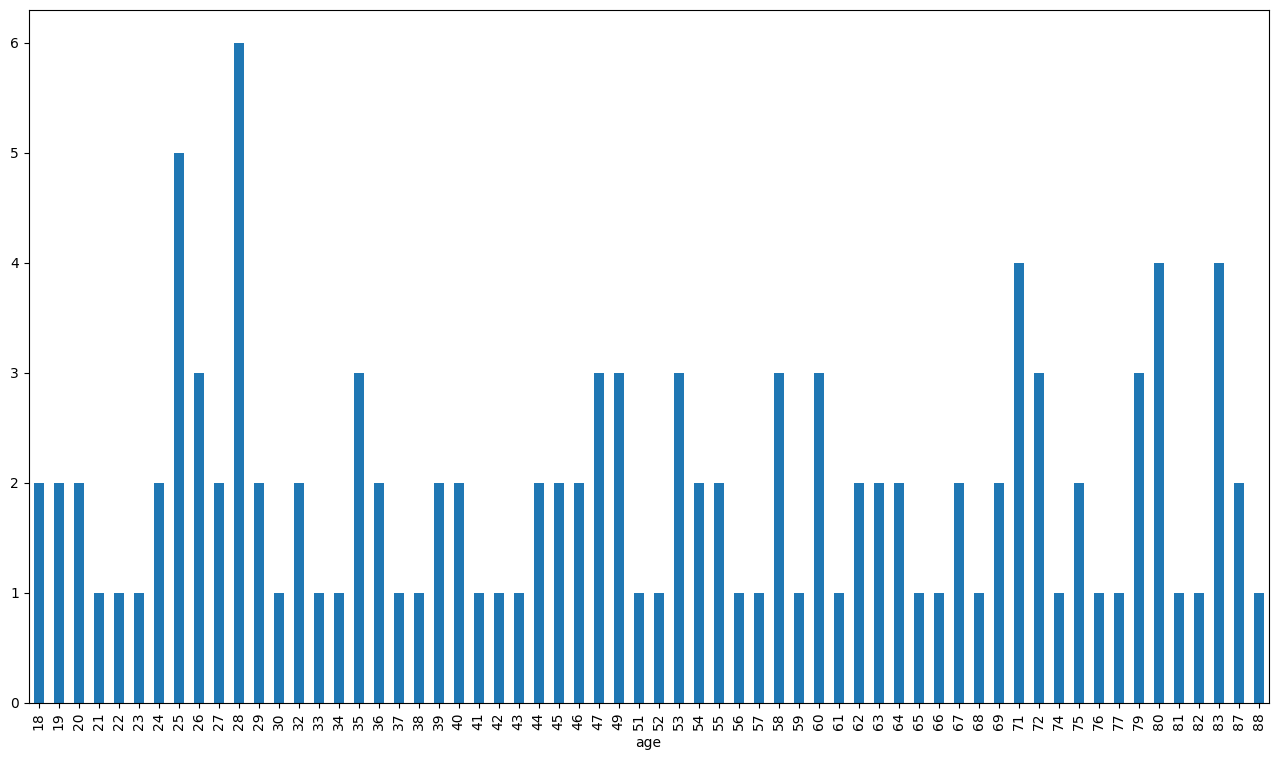

In [7]:
plt.figure(figsize=(16,9))
y_train['age'].value_counts().sort_index().plot(kind='bar')


<Axes: xlabel='age'>

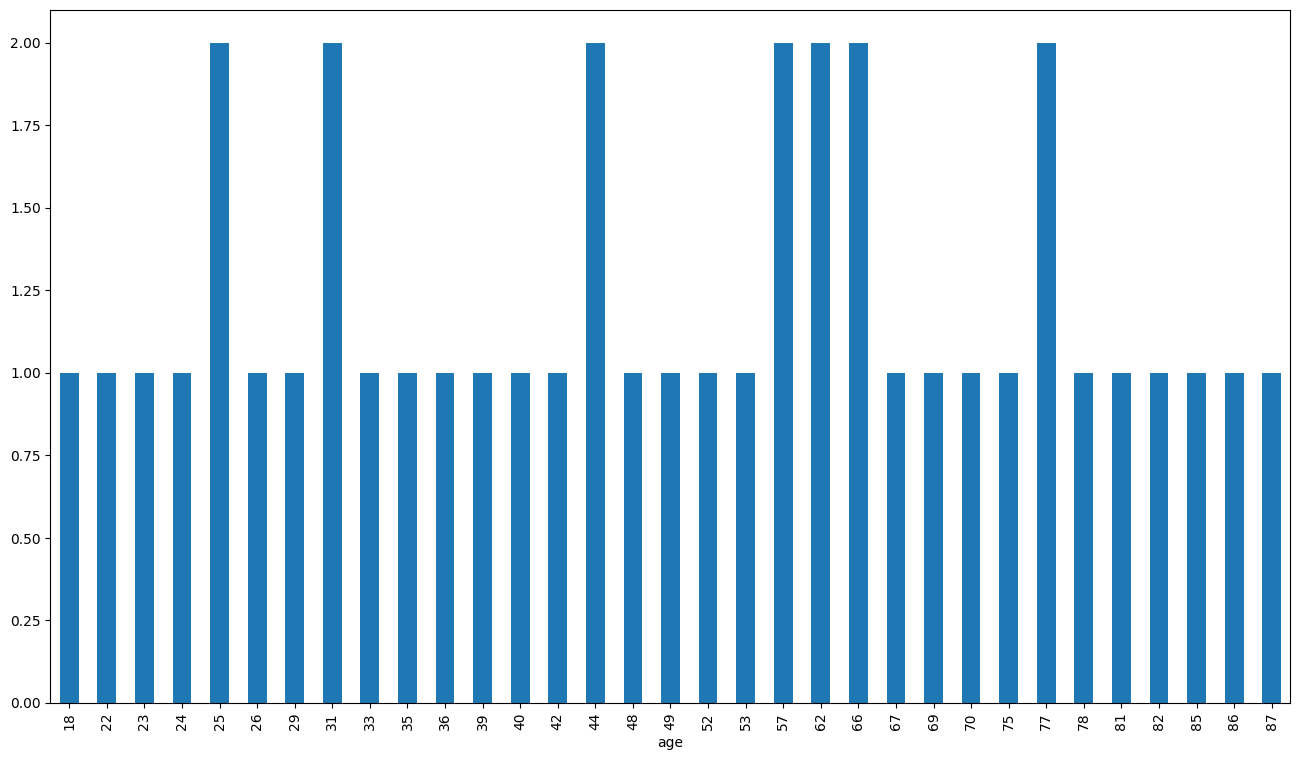

In [8]:
plt.figure(figsize=(16,9))
y_test['age'].value_counts().sort_index().plot(kind='bar')

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


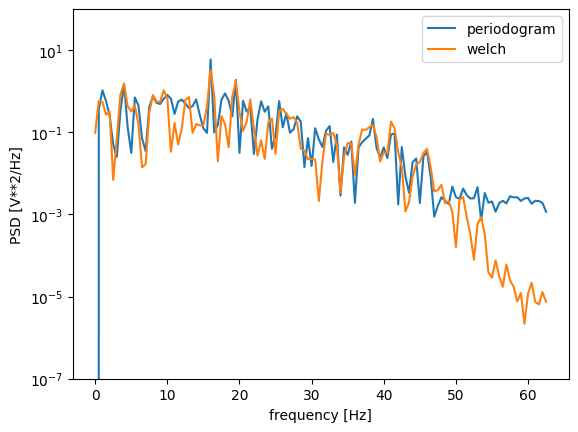

In [9]:
sample = train_data_reshaped[0][12]
PSD_plot(sample)

In [10]:
def hjorth_parameters(eeg_signal):
    """
    Calculates Hjorth parameters (Activity, Mobility, Complexity) for an EEG signal.
    
    Args:
    eeg_signal: A 1D NumPy array representing the EEG signal.
    
    Returns:
    A dictionary containing the Hjorth parameters:
    {'activity': activity, 'mobility': mobility, 'complexity': complexity}
    """
    # Calculate derivatives using central difference method
    first_derivative = np.diff(eeg_signal)
    second_derivative = np.diff(first_derivative)
    
    # Calculate variances
    var_signal = np.var(eeg_signal)
    var_first_derivative = np.var(first_derivative)
    var_second_derivative = np.var(second_derivative)

    if var_signal == 0:
        return np.array((0,0,0))    
    # Calculate Hjorth parameters
    activity = var_signal
    mobility = np.sqrt(var_first_derivative / var_signal)
    complexity = np.sqrt(var_second_derivative / var_first_derivative) / mobility
    
    return np.array((activity, mobility, complexity))

In [11]:
def extract_features(input_signal):
    psd = PSD(input_signal)
    hjorth = hjorth_parameters(input_signal)
    # stats = extract_statistical_measures(input_signal)
    return np.concatenate([ psd, hjorth])

In [12]:
def remove_zero_product_elements(arr, label=None):
    products = np.prod(arr, axis=2)  
    products = np.prod(products, axis=1)

    mask = products != 0 

    filtered_arr = arr[mask]
    if label is not None:
        filtered_label = label[mask]
    else:
        filtered_label = None
    
    return filtered_arr, filtered_label

In [13]:
train_data_reshaped, train_label_reshaped = remove_zero_product_elements(train_data_reshaped, train_label_reshaped)
test_data_reshaped, test_label_reshaped = remove_zero_product_elements(test_data_reshaped, test_label_reshaped)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [14]:
def apply_function_across_dim2(arr, func):
    reshaped_arr = arr.reshape(-1, arr.shape[2])
    print(reshaped_arr.shape)
    # Apply the function to each row (which corresponds to a 1D slice along dim 2)
    result = np.apply_along_axis(func, 1, arr=reshaped_arr)
    print(result.shape)
    # Reshape the result back to the original shape
    final_result = result.reshape(-1, 52, result.shape[1])
    print(arr.shape, final_result.shape)
    return final_result

In [15]:
train_data_reshaped = np.apply_along_axis(extract_features, axis=2, arr=train_data_reshaped)
test_data_reshaped = np.apply_along_axis(extract_features, axis=2, arr=test_data_reshaped)

In [16]:
test_data_reshaped.shape

(10671, 52, 133)

In [17]:
labels = pd.read_csv(PATH / 'y_train.csv').values.squeeze()

age_labels = labels[:, 1].astype(int)

num_classes = len(np.unique(age_labels))
print(f"Number of classes: {num_classes}")


Number of classes: 62


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import numpy as np

class EEGDatasetRegression(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

class EEGDataModule(pl.LightningDataModule):
    def __init__(self, train_data, train_labels, test_data, test_labels, batch_size=8):
        super().__init__()
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.batch_size = batch_size

    def setup(self, stage=None):
        # Prepare datasets
        self.train_dataset = EEGDatasetRegression(self.train_data, self.train_labels)
        self.test_dataset = EEGDatasetRegression(self.test_data, self.test_labels)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [19]:
batch_size = 128
eeg_dm = EEGDataModule(train_data_reshaped, train_label_reshaped, test_data_reshaped, test_label_reshaped, batch_size=batch_size)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import MeanSquaredError, MeanAbsoluteError

class EEGNetAgeRegressor(pl.LightningModule):
    def __init__(self,
                 Chans=52,          
                 Samples=250,        
                 F1=8,
                 D=2,
                 F2=16,
                 kernelLength=64,
                 dropoutRate=0.5,
                 learning_rate=1e-3,
                 weight_decay=1e-4):
        super().__init__()
        
        self.save_hyperparameters()  
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=F1,
            kernel_size=(1, kernelLength),
            padding=(0, kernelLength // 2),
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(F1)

        self.depthwise_conv = nn.Conv2d(
            in_channels=F1,
            out_channels=F1*D,
            kernel_size=(Chans, 1),
            groups=F1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(F1*D)
      
        
        self.elu = nn.ELU()
        
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(dropoutRate)
        
        self.sep_conv1 = nn.Conv2d(
            in_channels=F1*D,
            out_channels=F1*D,
            kernel_size=(1, 16), 
            padding=(0, 8),
            groups=F1*D,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(F1*D)
        
        self.sep_conv2 = nn.Conv2d(
            in_channels=F1*D,
            out_channels=F2,
            kernel_size=(1, 1),
            bias=False
        )
        self.bn4 = nn.BatchNorm2d(F2)
        
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(dropoutRate)
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(F2, 1)  
        
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()
        self.test_mae = MeanAbsoluteError()
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.depthwise_conv(x)
        x = self.bn2(x)
        x = self.elu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.sep_conv1(x)
        x = self.bn3(x)
        x = self.elu(x)
        
        x = self.sep_conv2(x)
        x = self.bn4(x)
        x = self.elu(x)
        
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        
        out = self.fc(x)
        return out.squeeze(-1)  
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch  
        preds = self.forward(x)
        loss = F.l1_loss(preds, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        
        mse_val = self.train_mse(preds, y)
        self.log("train_mse", mse_val, on_epoch=True, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = F.l1_loss(preds, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        
        mse_val = self.val_mse(preds, y)
        self.log("val_mse", mse_val, on_epoch=True, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = F.mse_loss(preds, y)
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        
        mse_val = self.test_mse(preds, y)
        self.log("test_mse", mse_val, on_epoch=True, prog_bar=True)

        mae_val = self.test_mae(preds, y)
        self.log("test_mae", mae_val, on_epoch=True, prog_bar=True)
        
        return loss


from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="EEG Competition", log_model=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-model-{epoch}-{val_loss:.2f}"
)
model = EEGNetAgeRegressor(
    Chans=52,
    Samples=train_data_reshaped.shape[2],
    F1=16,
    D=4,
    F2=32,
    kernelLength=64,
    dropoutRate=0.5,
    learning_rate=1e-3,
    weight_decay=1e-4
)

trainer = pl.Trainer(
    max_epochs=60, 
    accelerator="auto",  
    devices=1,
     logger=wandb_logger,
     callbacks=[checkpoint_callback]
)

trainer.fit(model, datamodule=eeg_dm)

trainer.test(model, datamodule=eeg_dm)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     399.1722412109375     │
│         test_mae          │    16.862211227416992     │
│         test_mse          │     399.1722412109375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 399.1722412109375,
  'test_mse': 399.1722412109375,
  'test_mae': 16.862211227416992}]